# M4L2 Screencasts

## M4L2SC1: Understanding Q-Learning and the Bellman Update

### Step 1: Introducing Actions and Rewards
Introduce basic Python code to simulate actions, states, and rewards.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rewards = np.array([
    [0, -1, 0, 1],  # Example rewards for state-action pairs
    [0, 0, 0, -1],
    [1, 0, 0, 0],
    [-1, 0, 0, 0],
])


### Step 2: Applying the Bellman Update
Action: Demonstrate the Bellman Update equation and its integration in Python.

In [ ]:
def bellman_update(q_table, state, action, reward, next_state, alpha=0.1, gamma=0.9):
    """Apply Bellman Update to the Q-table."""
    predict = q_table[state, action]
    target = reward + gamma * np.max(q_table[next_state, :])
    q_table[state, action] = predict + alpha * (target - predict)
    return q_table


### Step 3: Implementing Q-Learning with Iterations
Implement the Q-learning loop, simulating agent learning through iterations.

In [ ]:
num_states = 4
num_actions = 4
q_table = np.zeros((num_states, num_actions))

for episode in range(100):
    state = np.random.randint(0, num_states)
    while state != 2:  # Let's say reaching state '2' is the goal
        action = np.random.choice(num_actions)
        next_state = np.random.choice(num_states)
        reward = rewards[state, action]
        q_table = bellman_update(q_table, state, action, reward, next_state)
        state = next_state


## Step 4: Visualize the Path

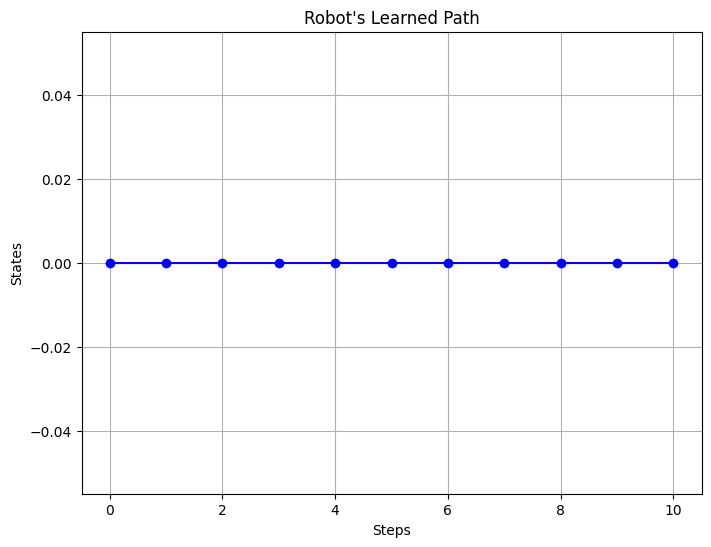

In [ ]:
def visualize_path(q_table):
    current_state = 0  # Start state
    path = [current_state]

    while current_state != 2:  # Until goal reached
        action = np.argmax(q_table[current_state])
        next_state = np.argmax(q_table[:, action])
        path.append(next_state)
        current_state = next_state
        if len(path) > 10:  # Prevent infinite loops
            break

    # Plot the path
    plt.figure(figsize=(8, 6))
    plt.plot(path, 'bo-')
    plt.grid(True)
    plt.title('Robot\'s Learned Path')
    plt.xlabel('Steps')
    plt.ylabel('States')
    plt.show()

# Let's see the path!
visualize_path(q_table)

## M4L2SC2: Implementing Q-Learning in GridWorld

### Step 1: Setting Up the GridWorld Environment
Initialize the GridWorld environment with specific states, actions, and a reward system.

In [ ]:
import numpy as np

class GridWorld:
    def __init__(self, size=5, start=(0, 0), goal=(4, 4)):
        self.size = size
        self.state = start
        self.goal = goal

    def reset(self):
        self.state = (0, 0)  # Reset to initial position
        return self.state

    def is_goal_reached(self):
        return self.state == self.goal

    def step(self, action):
        x, y = self.state
        if action == "right" and x < self.size - 1:
            x += 1
        elif action == "down" and y < self.size - 1:
            y += 1
        self.state = (x, y)
        reward = 1 if self.is_goal_reached() else -0.04  # Small penalty for each move
        return self.state, reward

### Step 2: Initializing the Q-Table
Define and initialize the Q-table for learning state-action values.

In [ ]:
num_states = 5 * 5  # Total states in a 5x5 grid
num_actions = 2  # Actions: right, down
q_table = np.zeros((num_states, num_actions))

### Step 3: Implementing the Q-Learning Loop
Implement the Q-learning loop to simulate agent learning across episodes.

In [ ]:
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:  # Exploration
        return np.random.choice(num_actions)
    else:  # Exploitation
        return np.argmax(q_table[state, :])

env = GridWorld()

alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
episodes = 1000

for episode in range(episodes):
    env.reset()
    state = env.state[0] * env.size + env.state[1]  # Encode state
    done = False
    while not done:
        action = choose_action(state, epsilon)
        next_state_tuple, reward = env.step(["right", "down"][action])
        next_state = next_state_tuple[0] * env.size + next_state_tuple[1]
        q_table[state, action] += alpha * (reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action])
        state = next_state
        if env.is_goal_reached():
            done = True


### Step 4: Observing and Reflecting on Learning Outcomes
Extract the learned Q-table values and interpret agent strategies.

In [ ]:
print("Learned Q-Table:")
print(q_table)

Learned Q-Table:
[[ 0.26961566  0.26949017]
 [ 0.34400116 -0.03179872]
 [ 0.11090103 -0.02835407]
 [-0.00997222 -0.01901906]
 [-0.01755431 -0.0157616 ]
 [ 0.3440174   0.34399646]
 [ 0.426686    0.18372791]
 [ 0.45235597 -0.02055823]
 [ 0.08687437 -0.01234696]
 [ 0.04375694 -0.01186582]
 [ 0.4245863   0.426686  ]
 [ 0.51843397  0.51854   ]
 [ 0.62018784  0.6206    ]
 [ 0.734       0.73302528]
 [ 0.85989485  0.36812032]
 [-0.02089844  0.51822137]
 [ 0.23284204  0.62059993]
 [ 0.46387667  0.734     ]
 [ 0.86        0.85990178]
 [ 1.          0.37235232]
 [-0.011524    0.07899772]
 [ 0.02690904  0.562785  ]
 [ 0.09624436  0.84066414]
 [ 0.85997554  1.        ]
 [ 0.          0.        ]]


## M4L2SC3: Building a Policy Network and Sampling Actions

### Step 1: Setting Up the Computational Environment

Import essential libraries and set up the GridWorld environment.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize a basic GridWorld environment
class GridWorld:
    def __init__(self):
        self.state = 0  # Initial state
        self.num_states = 16  # Four by four grid
        self.actions = ["up", "right", "down", "left"]

    def reset(self):
        self.state = 0
        return self.state


### Step 2: Building the Policy Network

Create a simple neural network to act as a policy network.

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(PolicyNetwork, self).__init__()
        self.linear1 = nn.Linear(num_inputs, 128)
        self.linear2 = nn.Linear(128, num_actions)

    def forward(self, state):
        x = torch.relu(self.linear1(state))
        x = self.linear2(x)
        return torch.softmax(x, dim=0)

### Step 3: Sampling Actions from the Network
Implement a function that samples actions based on the policy network's output.

In [ ]:
def select_action(policy_network, state):
    # Convert state to one-hot vector
    state_vector = torch.zeros(16)  # Create a vector of zeros
    state_vector[state] = 1  # Set the current state position to 1

    # Get action probabilities
    probs = policy_network(state_vector)
    action = np.random.choice(len(probs), p=probs.detach().numpy())
    return action

  # Let's try it out!
policy_network = PolicyNetwork(num_inputs=16, num_actions=4)
current_state = 0  # Robot starts at position 0
chosen_action = select_action(policy_network, current_state)
print(f"Robot's position: {current_state}")
print(f"Chosen action: {['up', 'right', 'down', 'left'][chosen_action]}")

Robot's position: 0
Chosen action: up


## M4L2SC4: Training with the REINFORCE Algorithm

### Step 1: Setting Up Your Environment
Import necessary libraries and set up a simple reinforcement learning environment.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define a simple environment (could be left incomplete for learning purposes)
class SimpleEnv:
    def reset(self):
        # Initialize state
        return 0

    def step(self, action):
        # Return new state, reward (described briefly for context)
        state, reward = ..., ...
        return state, reward


### Step 2: Building the Policy Network
Define a neural network to serve as the policy function approximator.

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=0)


### Step 3: Sampling Actions Using the Policy Network

Implement a function to sample actions using the policy network.

In [ ]:
def select_action(policy_network, state):
    state = torch.FloatTensor([state])
    probs = policy_network(state)
    action = np.random.choice(len(probs), p=probs.detach().numpy())
    return action

### Step 4: Implementing the REINFORCE Algorithm
Implement the REINFORCE algorithm to update policy network weights based on collected rewards.

In [ ]:
def reinforce(policy_network, optimizer):
    # (assume trajectory, rewards pre-computed during episode)
    optimizer.zero_grad()
    for log_prob, reward in zip(trajectory, rewards):
        loss = -log_prob * reward  # Calculate the policy gradient loss
        loss.backward()
    optimizer.step()


## Step 5: REINFORCE in Action

In [ ]:
# Let's see REINFORCE in action
policy_network = PolicyNetwork(num_inputs=4, num_actions=2)
optimizer = optim.Adam(policy_network.parameters(), lr=0.01)

# Create one-hot encoded state
state = torch.zeros(4)
state[0] = 1

# Get action probabilities and create trajectory with gradient tracking
probs = policy_network(state)
log_prob = torch.log(probs[0])  # Track gradients for this operation
trajectory = [log_prob]  # Store log probability
rewards = [1.0]

# Run REINFORCE
print("Before learning:")
print(f"Action probabilities: {policy_network(state).detach().numpy()}")

reinforce(policy_network, optimizer)

print("\nAfter learning:")
print(f"Action probabilities: {policy_network(state).detach().numpy()}")

Before learning:
Action probabilities: [0.46819288 0.53180707]

After learning:
Action probabilities: [0.5847601  0.41523987]
